In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

In [2]:
train_path ='archive/train/'
test_path = 'archive/test/'
classes = ['0', '1', '2', '3', '4', '5', '6']
num_classes = 7
x_pixels= 48
y_pixels= 48

# 1. EDA

## 1.1 count number of images in each class:

In [3]:
def count_images_exp_class(path,set_):
    classes_dict={}
    for folder_name in os.listdir(path):
        directory = path + folder_name
        classes_dict[folder_name]=len(os.listdir(directory))

    df = pd.DataFrame(classes_dict,index=[set_])
    return df

In [4]:
train_count=count_images_exp_class(train_path,'train_count')
print(train_count)

             happy   sad  fear  surprise  neutral  angry  disgust
train_count   7215  4830  4097      3171     4965   3995      436


In [5]:
test_count = count_images_exp_class(test_path,'test_count')
print(test_count)

            happy   sad  fear  surprise  neutral  angry  disgust
test_count   1774  1247  1024       831     1233    958      111


Text(0.5, 1.0, 'Train dataset')

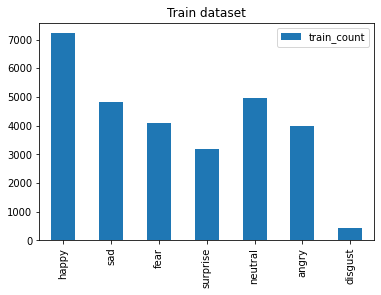

In [6]:
train_count.transpose().plot(kind = "bar")
plt.title('Train dataset')

Text(0.5, 1.0, 'Test dataset')

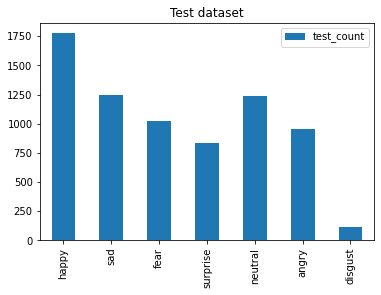

In [7]:
test_count.transpose().plot(kind = "bar")
plt.title('Test dataset')

## 1.2 show sample training images

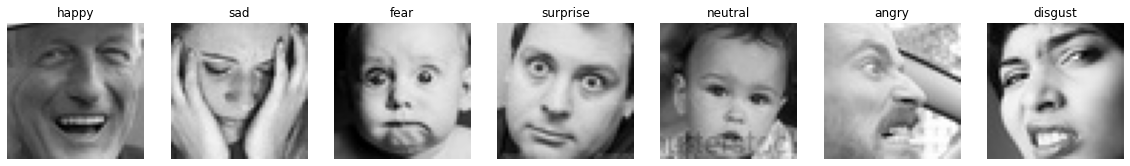

In [206]:
plt.figure(figsize=(20,22))
i = 1
for folder_name in os.listdir(train_path):
    img = keras.preprocessing.image.load_img((train_path + folder_name +'/'+ os.listdir(train_path + folder_name)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(folder_name)
    plt.axis('off')
    i += 1
plt.show()

# 2.  Preprocessing, making the train and test datasets

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Dense, MaxPooling2D,Flatten,Dropout,Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger,TensorBoard,EarlyStopping,ReduceLROnPlateau
import datetime
from tensorflow.keras.utils import plot_model

 #### making 3 different data generators, for trial and error, playing with the target_size, shuffle, and data augmentation using flip, rotation etc:
 
    * the train/test are stored both in 'achive/' (with folder names) and 'data/' (with folder numbers)

In [9]:
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True)
train_set=train_datagen.flow_from_directory(train_path,
                                            batch_size=64,
                                            target_size=(48,48),
                                            shuffle=True,
                                            color_mode="grayscale",class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                            batch_size=64,
                                            target_size=(48,48),
                                            shuffle=True,
                                            color_mode="grayscale",class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [51]:
#Spiced_version to compare
train_path_spiced ='data/train/'
test_path_spiced= 'data/test/'
train_datagen_spiced = ImageDataGenerator(rescale=1.0/255.0,validation_split=0.2) # rescale scales pixel values from 0-255 to 0-1 range

train_batches_spiced = train_datagen_spiced.flow_from_directory(directory=train_path_spiced, \
target_size=(224,224), classes=classes, batch_size=64,subset='training')

validation_batches_spiced = train_datagen_spiced.flow_from_directory(directory=train_path_spiced, \
target_size=(224,224), classes=classes, batch_size=64,subset='validation')

test_batches_spiced = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(\
directory=test_path_spiced, target_size=(224,224), classes=classes, \
batch_size=64, shuffle=False)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [150]:
# my_vesion to compare
train_path_siamak ='archive/train/'
test_path_siamak= 'archive/test/'

train_datagen_siamak = ImageDataGenerator(rescale=1./255, 
                                          rotation_range = 15,
                                          horizontal_flip=True,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1,
                                          fill_mode = 'nearest')

test_datagen_siamak = ImageDataGenerator(rescale=1./255)

train_set_siamak = train_datagen_siamak.flow_from_directory(train_path_siamak,
                                                            #images in FER-2013 dataset are grayscale and 48x48
                                                            target_size=(48,48),
                                                            batch_size=64,
                                                            shuffle=True,
                                                            color_mode="grayscale",
                                                            class_mode='categorical')

test_set_siamak = test_datagen_siamak.flow_from_directory(
                                                        test_path_siamak,
                                                        target_size=(48,48),
                                                        batch_size=64,
                                                        shuffle=True,
                                                        color_mode="grayscale",
                                                        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [215]:
ls archive_to_augment_train/train_class_disgust_to_augment/

disgust/


 #### trying the data Augmentaiton only on the "disgust" class
 
 * However, according to https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
 this does not increase the number of data (images) in that class

In [216]:
# my_second_vesion to compare
train_path_siamak_2_disgust_excluded ='archive_to_augment_train/train_class_disgust_excluded/'
train_path_siamak_2_class_disgust_to_augment ='archive_to_augment_train/train_class_disgust_to_augment/'

train_datagen_siamak_2_allbut_disgust = ImageDataGenerator(rescale=1./255)

train_datagen_siamak_2_only_disgust = ImageDataGenerator(rescale=1./255, 
                                          rotation_range = 15,
                                          horizontal_flip=True,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1,
                                          fill_mode = 'nearest')


train_set_siamak_2_allbut_disgust = train_datagen_siamak_2_allbut_disgust.flow_from_directory(train_path_siamak_2_disgust_excluded,
                                                            target_size=(48,48),
                                                            batch_size=64,
                                                            shuffle=True,
                                                            color_mode="grayscale",
                                                            class_mode='categorical')

train_set_siamak_2_only_disgust = train_datagen_siamak_2_only_disgust.flow_from_directory(train_path_siamak_2_class_disgust_to_augment,
                                                            target_size=(48,48),
                                                            batch_size=64,
                                                            shuffle=True,
                                                            color_mode="grayscale",
                                                            class_mode='categorical')

# I can use the same test_set_siamak here as well
test_set_siamak_2 = test_set_siamak

Found 28709 images belonging to 7 classes.
Found 436 images belonging to 1 classes.


In [11]:
train_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [12]:
#Spiced_version to follow
classes_dict =train_set.class_indices
classes_dict

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# 3) Building different models:

 ## 3.1 replicate a model from Kaggle (small modification)

In [13]:
#https://www.kaggle.com/code/ritikjain00/model-training-fer-13
# This model takes input_size = (48,48,1) 
def get_model(input_size, num_classes=7):
     #BUILDING the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))

    #COMPLILING the CNN
    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [14]:
ritikjain00_model = get_model((x_pixels,y_pixels,1),num_classes)
ritikjain00_model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)    

2022-06-05 20:33:56.359363: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-05 20:33:56.359477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 ## 3.2 The model based on spiced course scripts:

In [45]:
# spiced_version
from tensorflow.keras.layers import Activation, Dense, Flatten,\
BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential

spiced_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=7, activation='softmax')
])

In [46]:
spiced_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',\
metrics=['accuracy'])
spiced_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 128)     

## 3.3) A model based on transferred learning from MobileNet V2

In [73]:
# Transfer learning on MobileNet model
from tensorflow.keras.applications import mobilenet_v2
base_model_mobilenet = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

In [74]:
base_model_mobilenet.trainable = False

In [89]:
transfered_mobilenet_model = keras.Sequential() # defining a new model
transfered_mobilenet_model.add(base_model_mobilenet) # adding in the pretrained model without the fully connected layer
transfered_mobilenet_model.add(keras.layers.Dense(64, activation='relu')) # adding in additional layers
transfered_mobilenet_model.add(keras.layers.Dropout(0.25))
transfered_mobilenet_model.add(keras.layers.Dense(7, activation='softmax'))
transfered_mobilenet_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.35_224 (Funct  (None, 1280)             410208    
 ional)                                                          
                                                                 
 dense_15 (Dense)            (None, 64)                81984     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 7)                 455       
                                                                 
Total params: 492,647
Trainable params: 82,439
Non-trainable params: 410,208
_________________________________________________________________


In [91]:
transfered_mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',\
metrics=['accuracy'])

## 3.4 Designed a final model after several trial and errors: siamak_model

In [155]:
siamak_model = Sequential()

siamak_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48,48,1)))
siamak_model.add(Dropout(0.1))

siamak_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
siamak_model.add(Dropout(0.1))

siamak_model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
siamak_model.add(Dropout(0.2))

siamak_model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
siamak_model.add(MaxPooling2D(pool_size=(2, 2)))
siamak_model.add(Dropout(0.2))

siamak_model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
siamak_model.add(Dropout(0.3))

siamak_model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
siamak_model.add(MaxPooling2D(pool_size=(2, 2)))
siamak_model.add(Dropout(0.3))

siamak_model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
siamak_model.add(Dropout(0.4))

siamak_model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
siamak_model.add(MaxPooling2D(pool_size=(2, 2)))
siamak_model.add(Dropout(0.4))

siamak_model.add(Flatten())
siamak_model.add(Dense(1024, activation='relu'))
siamak_model.add(Dropout(0.5))
siamak_model.add(Dense(7, activation='softmax'))

In [156]:
siamak_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 dropout_16 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 dropout_17 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 dropout_18 (Dropout)        (None, 48, 48, 128)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 48, 48, 128)     

In [157]:
siamak_model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


## 3.5 Plot all 4 model architectures

In [ ]:
#pip install --upgrade pip
#!pip install pydot
#!pip install graphviz

 * horizontally

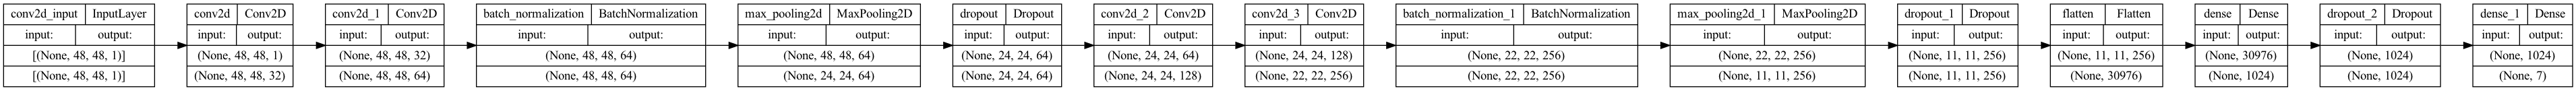

In [201]:
#tf.keras.utils.plot_model(ritikjain00_model,to_file='ritikjain00_model.png',show_shapes=True,show_dtype=False,show_layer_names=True,
#    rankdir='LR',expand_nested=False,dpi=96,layer_range=None, show_layer_activations=False)
#tf.keras.utils.plot_model(transfered_mobilenet_model,to_file='transfered_mobilenet_model.png',show_shapes=True,show_dtype=False,show_layer_names=True,
#    rankdir='LR',expand_nested=False,dpi=96,layer_range=None, show_layer_activations=False)
#tf.keras.utils.plot_model(spiced_model,to_file='spiced_model.png',show_shapes=True,show_dtype=False,show_layer_names=True,
#    rankdir='LR',expand_nested=False,dpi=96,layer_range=None, show_layer_activations=False)
#tf.keras.utils.plot_model(siamak_model,to_file='siamak_model.png',show_shapes=True,show_dtype=False,show_layer_names=True,
#    rankdir='LR',expand_nested=False,dpi=96,layer_range=None, show_layer_activations=False)

 *  Vertically

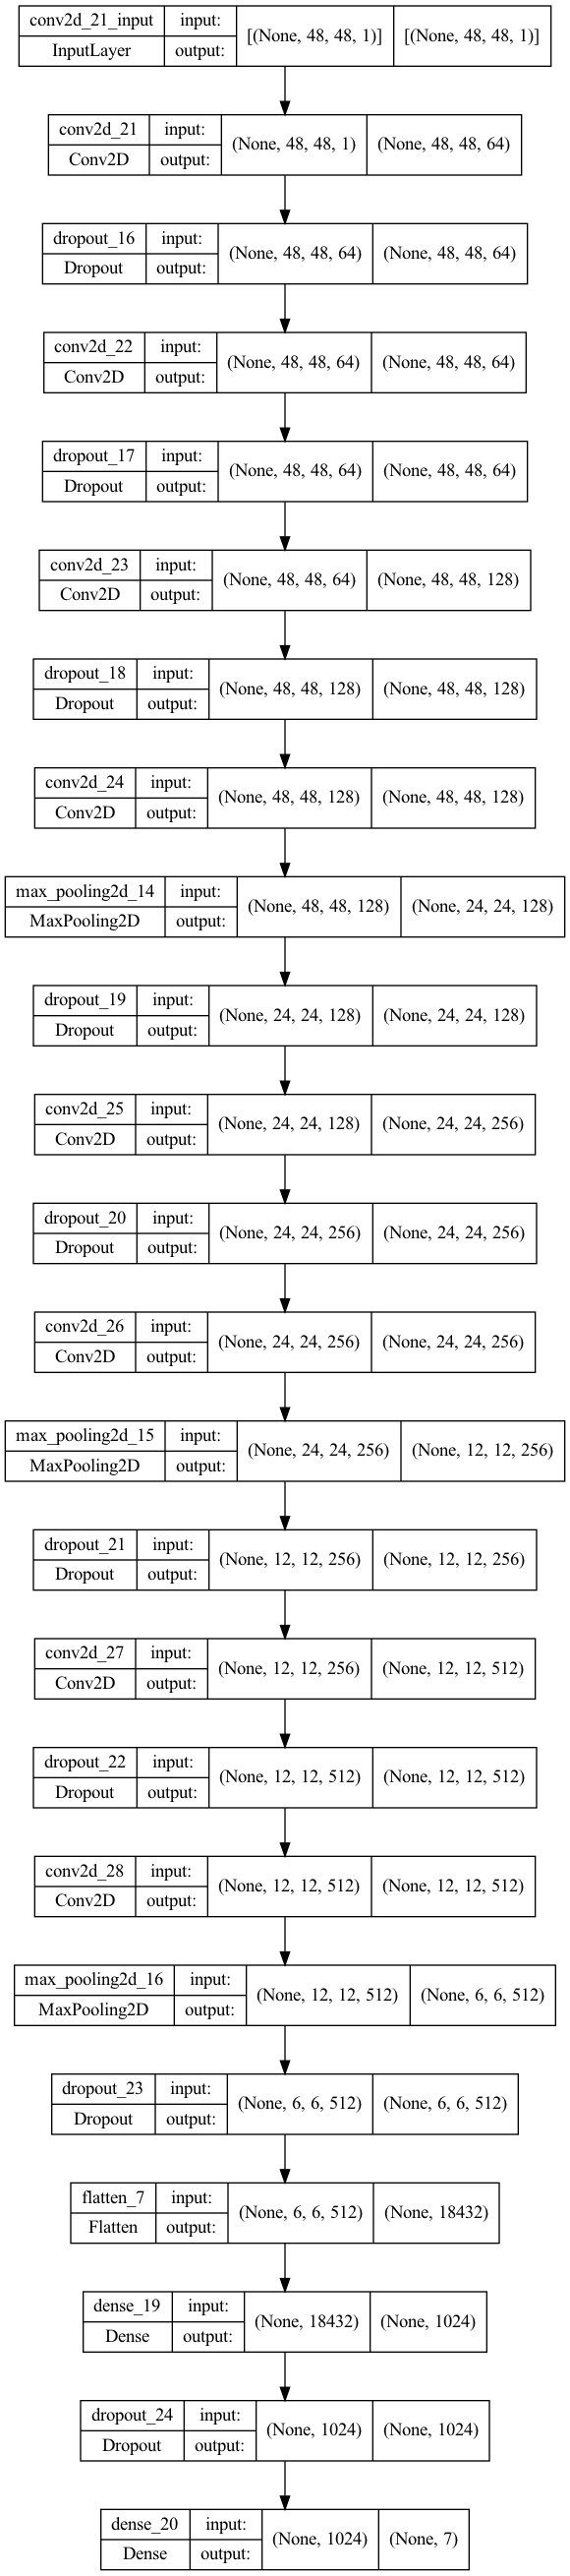

In [198]:
#save plots vertically
#tf.keras.utils.plot_model(ritikjain00_model,to_file='ritikjain00_model_TD.png',show_shapes=True,show_dtype=False,show_layer_names=True,
#    rankdir='TD',expand_nested=False,dpi=96,layer_range=None, show_layer_activations=False)
#tf.keras.utils.plot_model(transfered_mobilenet_model,to_file='transfered_mobilenet_model_TD.png',show_shapes=True,show_dtype=False,show_layer_names=True,
#    rankdir='TD',expand_nested=False,dpi=96,layer_range=None, show_layer_activations=False)
#tf.keras.utils.plot_model(spiced_model,to_file='spiced_model_TD.png',show_shapes=True,show_dtype=False,show_layer_names=True,
#    rankdir='TD',expand_nested=False,dpi=96,layer_range=None, show_layer_activations=False)
#tf.keras.utils.plot_model(siamak_model,to_file='siamak_model_TD.png',show_shapes=True,show_dtype=False,show_layer_names=True,
#    rankdir='TD',expand_nested=False,dpi=96,layer_range=None, show_layer_activations=False)

# 4. Train the models


### 4.1 train kaggle (ritikjain00) model,  save model, save weights, save architectue json

In [24]:
# commented out this line to avoid retraining the model whene rerunnung the notebook
#mod = ritikjain00_model.fit(x=train_set,
                 validation_data=test_set,
                 epochs=60,
                 steps_per_epoch= train_set.n // train_set.batch_size,
                 validation_steps=test_set.n // test_set.batch_size)

Epoch 1/60


2022-06-05 20:41:07.427643: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-05 20:41:07.657286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - ETA: 0s - loss: 4.2357 - accuracy: 0.3115

2022-06-05 20:41:37.924760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - 32s 67ms/step - loss: 4.2357 - accuracy: 0.3115 - val_loss: 6.6811 - val_accuracy: 0.2245
Epoch 2/60
448/448 [==============================] - 29s 65ms/step - loss: 3.4307 - accuracy: 0.3878 - val_loss: 3.1887 - val_accuracy: 0.3970
Epoch 3/60
448/448 [==============================] - 29s 64ms/step - loss: 2.8895 - accuracy: 0.4291 - val_loss: 2.6007 - val_accuracy: 0.4688
Epoch 4/60
448/448 [==============================] - 29s 64ms/step - loss: 2.4642 - accuracy: 0.4654 - val_loss: 2.2657 - val_accuracy: 0.4848
Epoch 5/60
448/448 [==============================] - 29s 65ms/step - loss: 2.1430 - accuracy: 0.4922 - val_loss: 1.9896 - val_accuracy: 0.5119
Epoch 6/60
448/448 [==============================] - 29s 65ms/step - loss: 1.8919 - accuracy: 0.5230 - val_loss: 1.8085 - val_accuracy: 0.5205
Epoch 7/60
448/448 [==============================] - 29s 65ms/step - loss: 1.6945 - accuracy: 0.5462 - val_loss: 1.6353 - val_accuracy: 0.5491
Epo

In [25]:
model_json=ritikjain00_model.to_json()
with open("ritikjain00_model.json","w") as json_file:
    json_file.write(model_json)

In [26]:
ritikjain00_model.save_weights('ritikjain00_model_best_weights.h5')

In [99]:
# serialize model according to course material
ritikjain00_model.save("models/ritikjain00_model.h5")
ritikjain00_model = load_model("models/ritikjain00_model.h5")

### 4.2 train spiced_model, save and load the model
in order to plot the performace consistent with other models

In [52]:
hist = spiced_model.fit(
train_batches_spiced,
validation_data = validation_batches_spiced, 
epochs = 10)

Epoch 1/10


2022-06-06 11:13:49.368944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - ETA: 0s - loss: 1.6971 - accuracy: 0.3268

2022-06-06 11:14:45.016981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - 60s 164ms/step - loss: 1.6971 - accuracy: 0.3268 - val_loss: 1.6003 - val_accuracy: 0.3914
Epoch 2/10
359/359 [==============================] - 59s 163ms/step - loss: 1.5390 - accuracy: 0.4153 - val_loss: 1.5317 - val_accuracy: 0.4189
Epoch 3/10
359/359 [==============================] - 59s 163ms/step - loss: 1.4508 - accuracy: 0.4530 - val_loss: 1.4833 - val_accuracy: 0.4445
Epoch 4/10
359/359 [==============================] - 58s 163ms/step - loss: 1.3596 - accuracy: 0.4907 - val_loss: 1.4593 - val_accuracy: 0.4567
Epoch 5/10
359/359 [==============================] - 58s 163ms/step - loss: 1.2799 - accuracy: 0.5250 - val_loss: 1.4780 - val_accuracy: 0.4541
Epoch 6/10
359/359 [==============================] - 59s 164ms/step - loss: 1.2147 - accuracy: 0.5529 - val_loss: 1.4335 - val_accuracy: 0.4686
Epoch 7/10
359/359 [==============================] - 59s 163ms/step - loss: 1.1542 - accuracy: 0.5769 - val_loss: 1.4476 - val_accuracy: 0.4

In [98]:
spiced_model.save("models/spiced_model.h5")
spiced_model = load_model("models/spiced_model.h5")

 ###  4.3 train transfered_mobilenet_model, save and load the model

In [93]:
transfered_mobilenet_model_hist = transfered_mobilenet_model.fit(
train_batches_spiced,
validation_data = validation_batches_spiced, 
epochs = 60)

Epoch 1/60
359/359 [==============================] - ETA: 0s - loss: 1.7850 - accuracy: 0.2802

2022-06-06 19:54:43.765201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - 24s 66ms/step - loss: 1.7850 - accuracy: 0.2802 - val_loss: 1.6312 - val_accuracy: 0.3545
Epoch 2/60
359/359 [==============================] - 23s 64ms/step - loss: 1.6095 - accuracy: 0.3709 - val_loss: 1.5507 - val_accuracy: 0.4018
Epoch 3/60
359/359 [==============================] - 23s 64ms/step - loss: 1.5506 - accuracy: 0.4013 - val_loss: 1.5150 - val_accuracy: 0.4149
Epoch 4/60
359/359 [==============================] - 23s 64ms/step - loss: 1.5092 - accuracy: 0.4228 - val_loss: 1.4839 - val_accuracy: 0.4325
Epoch 5/60
359/359 [==============================] - 23s 64ms/step - loss: 1.4821 - accuracy: 0.4347 - val_loss: 1.4647 - val_accuracy: 0.4403
Epoch 6/60
359/359 [==============================] - 23s 64ms/step - loss: 1.4577 - accuracy: 0.4452 - val_loss: 1.4478 - val_accuracy: 0.4431
Epoch 7/60
359/359 [==============================] - 23s 64ms/step - loss: 1.4352 - accuracy: 0.4556 - val_loss: 1.4331 - val_accuracy: 0.4494
Epo

In [97]:
transfered_mobilenet_model.save("models/transfered_mobilenet_model.h5")
transfered_mobilenet_model = load_model("models/transfered_mobilenet_model.h5")

### 4.4 train siamak_model, save and load the model

In [159]:
# long training time!
#siamak_model_hist = siamak_model.fit(
                            train_set_siamak,
                            steps_per_epoch=28709 // 64,
                            epochs=60,
                            validation_data=test_set_siamak,
                            validation_steps=7178 // 64)

Epoch 1/60


2022-06-07 21:11:33.430417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - ETA: 0s - loss: 1.8185 - accuracy: 0.2484

2022-06-07 21:13:20.384466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - 114s 251ms/step - loss: 1.8185 - accuracy: 0.2484 - val_loss: 1.8717 - val_accuracy: 0.2479
Epoch 2/60
448/448 [==============================] - 112s 251ms/step - loss: 1.7799 - accuracy: 0.2590 - val_loss: 1.7721 - val_accuracy: 0.2535
Epoch 3/60
448/448 [==============================] - 112s 251ms/step - loss: 1.7227 - accuracy: 0.2996 - val_loss: 1.6329 - val_accuracy: 0.3673
Epoch 4/60
448/448 [==============================] - 112s 251ms/step - loss: 1.6117 - accuracy: 0.3682 - val_loss: 1.4598 - val_accuracy: 0.4408
Epoch 5/60
448/448 [==============================] - 112s 251ms/step - loss: 1.5053 - accuracy: 0.4162 - val_loss: 1.3661 - val_accuracy: 0.4855
Epoch 6/60
448/448 [==============================] - 112s 251ms/step - loss: 1.4227 - accuracy: 0.4502 - val_loss: 1.3224 - val_accuracy: 0.4869
Epoch 7/60
448/448 [==============================] - 112s 251ms/step - loss: 1.3459 - accuracy: 0.4827 - val_loss: 1.2333 - val_accura

Epoch 57/60
448/448 [==============================] - 112s 251ms/step - loss: 0.7339 - accuracy: 0.7239 - val_loss: 0.8862 - val_accuracy: 0.6830
Epoch 58/60
448/448 [==============================] - 112s 250ms/step - loss: 0.7389 - accuracy: 0.7232 - val_loss: 0.8897 - val_accuracy: 0.6857
Epoch 59/60
448/448 [==============================] - 112s 251ms/step - loss: 0.7261 - accuracy: 0.7287 - val_loss: 0.8957 - val_accuracy: 0.6815
Epoch 60/60
448/448 [==============================] - 1078s 2s/step - loss: 0.7217 - accuracy: 0.7327 - val_loss: 0.8930 - val_accuracy: 0.6822


In [160]:
siamak_model.save("models/siamak_model.h5")
siamak_model = load_model("models/siamak_model.h5")

# 5. Performance Plots

### 5.1 Performance of Kaggle model (ritikjain00)

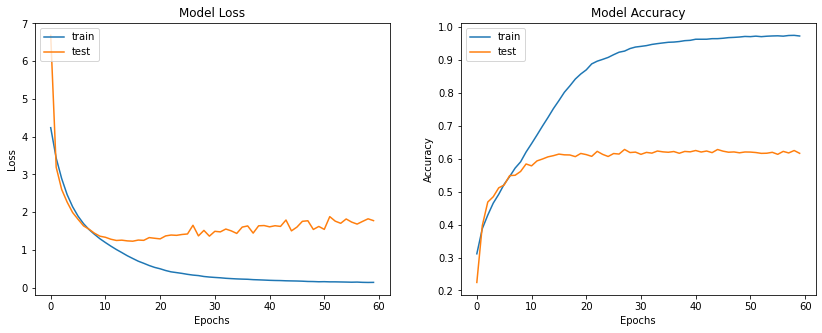

In [104]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(mod.history['accuracy'])
plt.plot(mod.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(mod.history['loss'])
plt.plot(mod.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



### 5.2 Performance of spiced model:

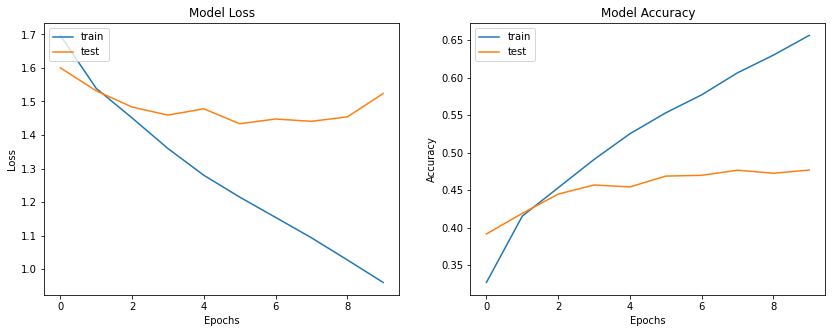

In [110]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 5.3 Performance of the transferred mobilenet model

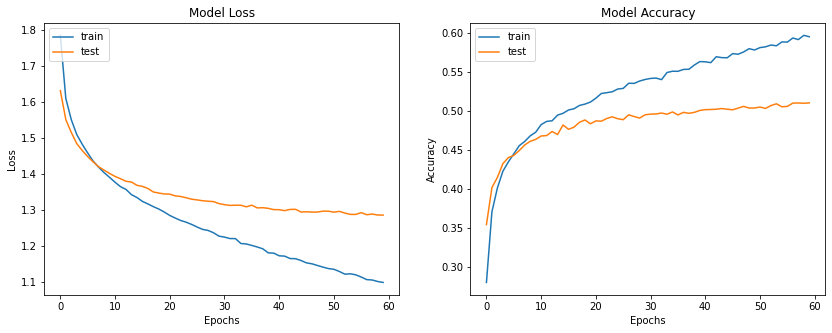

In [112]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(transfered_mobilenet_model_hist.history['accuracy'])
plt.plot(transfered_mobilenet_model_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(transfered_mobilenet_model_hist.history['loss'])
plt.plot(transfered_mobilenet_model_hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 5.4 Performance of the Siamak model

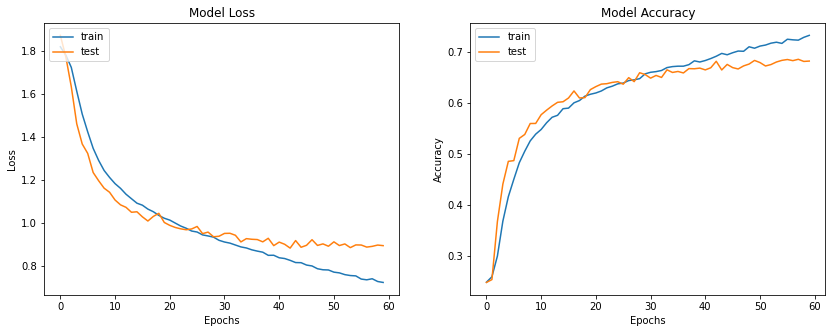

In [161]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(siamak_model_hist.history['accuracy'])
plt.plot(siamak_model_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(siamak_model_hist.history['loss'])
plt.plot(siamak_model_hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# 6. Evaluate Model Metrics:

### 6.1 Kaggle model (ritikjain00)

In [55]:
train_loss_ritikjain00, train_accu_ritikjain00 = ritikjain00_model.evaluate(train_set)
test_loss_ritikjain00, test_accu_ritikjain00 = ritikjain00_model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu_ritikjain00*100, test_accu_ritikjain00*100))

113/113 [==============================] - 2s 17ms/step - loss: 1.7740 - accuracy: 0.6167
final train accuracy = 99.59 , validation accuracy = 61.67


### 6.2 spiced model

In [58]:
train_loss_spiced, train_accu_spiced = spiced_model.evaluate(train_batches_spiced)
test_loss_spiced, test_accu_spiced = spiced_model.evaluate(test_batches_spiced)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu_spiced*100, test_accu_spiced*100))

113/113 [==============================] - 5s 44ms/step - loss: 1.5000 - accuracy: 0.4823
final train accuracy = 69.24 , validation accuracy = 48.23


### 6.3 transferred mobilenet model

In [203]:
train_loss_transferred_mobilenet, train_accu_transferred_mobilenet = transfered_mobilenet_model.evaluate(train_batches_spiced)
test_loss_transferred_mobilenet, test_accu_transferred_mobilenet = transfered_mobilenet_model.evaluate(test_batches_spiced)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu_transferred_mobilenet*100, test_accu_transferred_mobilenet*100))

113/113 [==============================] - 6s 50ms/step - loss: 1.2861 - accuracy: 0.5148
final train accuracy = 62.74 , validation accuracy = 51.48


### 6.4 Siamak model

In [204]:
train_loss_siamak, train_accu_siamak = siamak_model.evaluate(train_set_siamak)
test_loss_siamak, test_accu_siamak = siamak_model.evaluate(test_set_siamak)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu_siamak*100, test_accu_siamak*100))

  2/449 [..............................] - ETA: 26s - loss: 0.6424 - accuracy: 0.7500 

2022-06-08 11:21:44.978935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 7s 58ms/step - loss: 0.8935 - accuracy: 0.6822
final train accuracy = 78.93 , validation accuracy = 68.22


# 7. Confusion Matrics

### using the following function from course material to plot confusion matrix manually

In [245]:
import itertools
def plot_confusion_matrix_manual(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #cm = round
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# you could either use this custom function or the built in function from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# example for itertools.product() : https://www.geeksforgeeks.org/python-itertools-product/

In [246]:
cm

array([[156,  11, 107, 231, 177, 150, 126],
       [ 18,   1,  10,  22,  21,  20,  19],
       [152,   5, 129, 237, 169, 175, 157],
       [317,  20, 204, 386, 315, 270, 262],
       [195,  12, 135, 303, 200, 209, 179],
       [185,  15, 127, 292, 231, 208, 189],
       [118,   4,  86, 193, 150, 138, 142]])

In [247]:
from sklearn.metrics import confusion_matrix
import operator
from sklearn.metrics import plot_confusion_matrix

### 7.1 Kaggle model  (ritikjain00)

Confusion matrix, without normalization
[[157  10 100 224 174 164 129]
 [ 18   0  16  30  14  17  16]
 [178  12 128 219 186 158 143]
 [281  19 193 401 304 281 295]
 [196  10 126 297 217 223 164]
 [201   8 141 284 226 192 195]
 [110   9  94 209 142 135 132]]


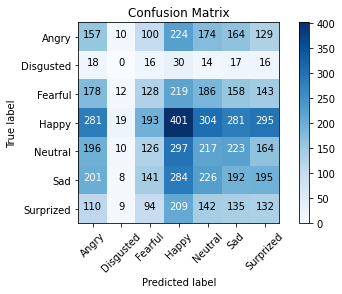

In [258]:
predictions_ritikjain00 =  ritikjain00_model.predict(x=test_set, verbose=0)
cm = confusion_matrix(y_true=test_set.classes, \
                      y_pred=np.argmax(predictions_ritikjain00, axis=-1))
#cm = np.round(cm, decimals=2, out=None)
cm_plot_labels = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprized']
plot_confusion_matrix_manual(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### 7.2 Spiced model

Confusion matrix, without normalization
[[ 321    1   51  186  117  243   39]
 [  27   26    8   16    8   23    3]
 [ 131    5  172  142  139  329  106]
 [  80    4   31 1324  108  192   35]
 [ 100    4   29  197  553  309   41]
 [ 169    2   61  207  206  561   41]
 [  45    1   54   96   60   70  505]]


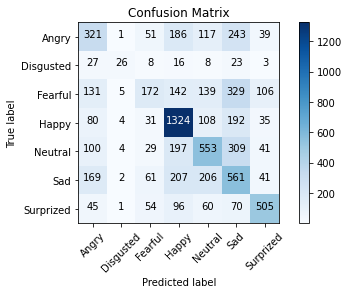

In [257]:
predictions_spiced =  spiced_model.predict(x=test_batches_spiced, verbose=0)
cm = confusion_matrix(y_true=test_batches_spiced.classes, \
                      y_pred=np.argmax(predictions_spiced, axis=-1))

cm_plot_labels = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprized']
plot_confusion_matrix_manual(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### 7.3 Transferred Mobilenet model

Confusion matrix, without normalization
[[ 341    3   92  144  145  184   49]
 [  29    8   32   12    5   22    3]
 [ 109    2  320  112  124  225  132]
 [  61    0   75 1343  129  119   47]
 [  82    1   90  198  610  203   49]
 [ 123    2  146  193  218  541   24]
 [  39    0   96   66   75   23  532]]


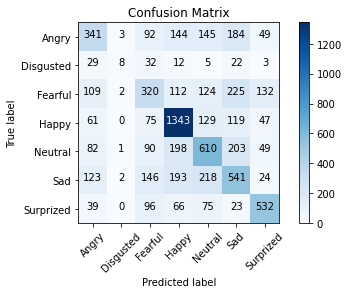

In [256]:
predictions_transferred_mobilenet =  transfered_mobilenet_model.predict(x=test_batches_spiced, verbose=0)
cm = confusion_matrix(y_true=test_batches_spiced.classes, \
                      y_pred=np.argmax(predictions_transferred_mobilenet, axis=-1))

cm_plot_labels = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprized']
plot_confusion_matrix_manual(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### 7.4 Siamak model

Confusion matrix, without normalization
[[122  24 114 232 194 141 131]
 [ 12   2  14  38  17  16  12]
 [151  19 134 233 195 162 130]
 [253  33 221 423 305 301 238]
 [155  25 150 301 245 213 144]
 [189  24 141 282 247 201 163]
 [ 87  12 105 220 175 143  89]]


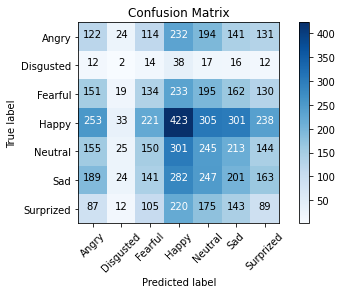

In [259]:
predictions_siamak =  siamak_model.predict(x=test_set_siamak, verbose=0)
cm = confusion_matrix(y_true=test_set_siamak.classes, \
                      y_pred=np.argmax(predictions_siamak, axis=-1))

cm_plot_labels = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprized']
plot_confusion_matrix_manual(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')